## Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

## Importing the dataset 

In [2]:
x = pd.read_csv('MCI_demo.csv')
df = pd.DataFrame(x)
df = df.astype(int)
df.head()

,Neighbourhood Number,Total Number of Crimes,Population,Working Age (25-54 years),Seniors (65+ years),Average household size,Persons living alone (total),Total - Income statistics,Total - Low-income status,Total - Immigrant,Total visible minority population,"Total - Highest certificate, diploma or degree",Total income: Average amount ($)
0,1,5702,33312,13845,4980,3,1800,1555,32885,32890,26945,27845,31771
1,2,2591,32954,13615,3560,3,1510,2230,32825,32830,28455,25730,26548
2,3,692,10360,4160,1880,3,575,605,10125,10125,6510,8395,32815
3,4,810,10529,4300,1730,2,985,685,10360,10360,5365,8725,34418
4,5,593,9456,3700,1275,2,640,800,9450,9445,6365,7640,32012


In [3]:
X = df.drop(['Total Number of Crimes','Neighbourhood Number'], axis = 1) # Feature Matrix
y = df['Total Number of Crimes']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 13 columns):
Neighbourhood Number                              140 non-null int32
Total Number of Crimes                            140 non-null int32
Population                                        140 non-null int32
Working Age (25-54 years)                         140 non-null int32
Seniors (65+ years)                               140 non-null int32
 Average household size                           140 non-null int32
Persons living alone (total)                      140 non-null int32
Total - Income statistics                         140 non-null int32
Total - Low-income status                         140 non-null int32
Total - Immigrant                                 140 non-null int32
  Total visible minority population               140 non-null int32
Total - Highest certificate, diploma or degree    140 non-null int32
Total income: Average amount ($)                  140 non-null int3

## Filter method 

### Pearson Correlation heatmap 

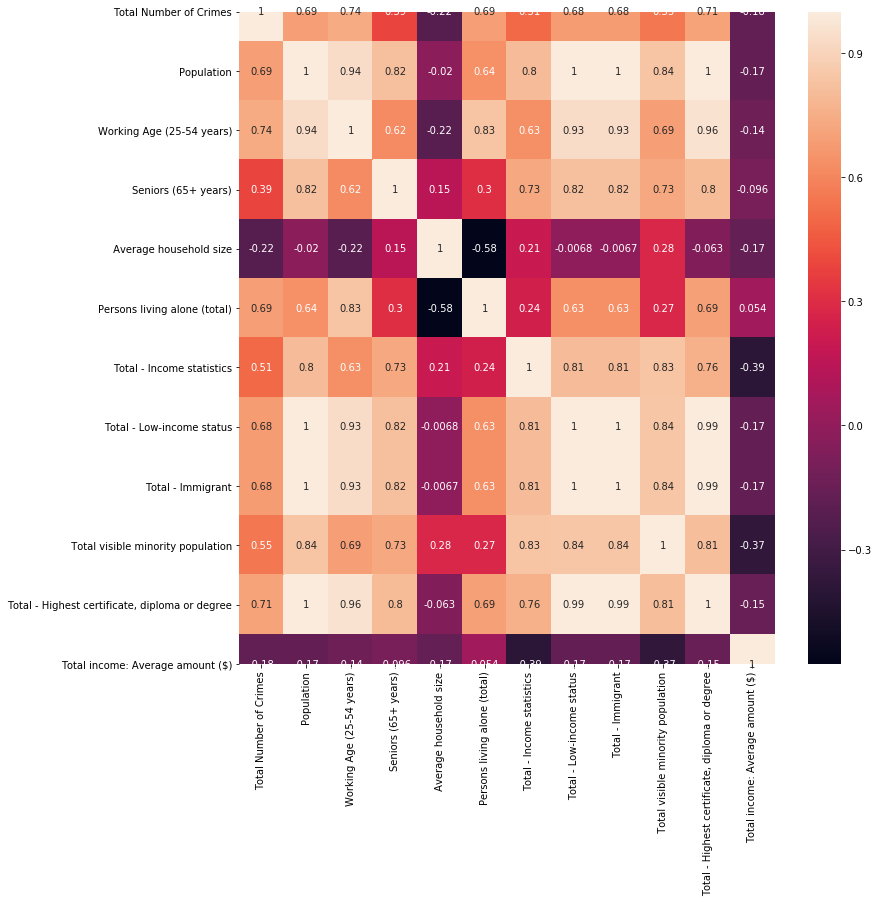

In [5]:
df.drop('Neighbourhood Number', axis = 1, inplace = True)
cor = df.corr()
plt.figure(figsize = (12,12))
sns.heatmap(cor, annot = True)
plt.show()

In [6]:
cor_target = abs(cor['Total Number of Crimes']) #correlation with output variable
relevant_features = cor_target[cor_target > 0.5]
relevant_features.drop('Total Number of Crimes').sort_values(ascending = False)

Working Age (25-54 years)                         0.739422
Total - Highest certificate, diploma or degree    0.710472
Population                                        0.691999
Persons living alone (total)                      0.689744
Total - Immigrant                                 0.684976
Total - Low-income status                         0.684970
  Total visible minority population               0.554126
Total - Income statistics                         0.506574
Name: Total Number of Crimes, dtype: float64

Most relevant features based on correlation value. 

## Wrapper Methods 

### Backward Elimination 

All features are fed into the model. Iteratively, the worst performing features are removed one by one till the overall performance of the model comes in acceptable range.

In [7]:
X_1 = sm.add_constant (X) # adding constant column of ones
model = sm.OLS(y,X_1).fit() # fitting sm.OLS model
model.pvalues

D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                                             9.583879e-02
Population                                        3.303649e-12
Working Age (25-54 years)                         4.077379e-14
Seniors (65+ years)                               1.565164e-17
 Average household size                           2.501319e-02
Persons living alone (total)                      9.756411e-05
Total - Income statistics                         3.592500e-02
Total - Low-income status                         9.913983e-01
Total - Immigrant                                 5.372674e-01
  Total visible minority population               6.099254e-01
Total - Highest certificate, diploma or degree    7.217979e-11
Total income: Average amount ($)                  2.332600e-01
dtype: float64

In [8]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p=pd.Series(model.pvalues.values[1:],index=cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['Population', 'Working Age (25-54 years)', 'Seniors (65+ years)', ' Average household size', 'Persons living alone (total)', 'Total - Income statistics', 'Total - Immigrant', 'Total - Highest certificate, diploma or degree']


### Recursive Feature Elimination 

Recursively removes attributes and builds model on the remaining attributes. Uses accuracy metric to rank features based on importance.

In [9]:
model = LinearRegression()

rfe = RFE(model,7) # Initializing RFE model

X_rfe = rfe.fit_transform(X,y) # Transforming data using RFE

model.fit(X_rfe,y) # Fitting data to model
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False  True False  True False  True False]
[1 1 1 1 2 1 3 1 4 1 5]


The variables are ranked with 1 being most important. True indicates that the feature is relavant.

### Listing relevant features

In [10]:
cols = list(X.columns)
model = LinearRegression()

rfe = RFE(model, 7) #Initializing RFE model            

X_rfe = rfe.fit_transform(X,y) #Transforming data using RFE  

model.fit(X_rfe,y) #Fitting the data to model              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Population', 'Working Age (25-54 years)', 'Seniors (65+ years)',
       ' Average household size', 'Total - Income statistics',
       'Total - Immigrant', 'Total - Highest certificate, diploma or degree'],
      dtype='object')


## Embedded methods 

Extracts features that contribute to training. 

### Lasso regularization 

If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [11]:
reg = LassoCV(max_iter=100000)
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 8520.590981
Best score using built-in LassoCV: 0.786346


In [12]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 1 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

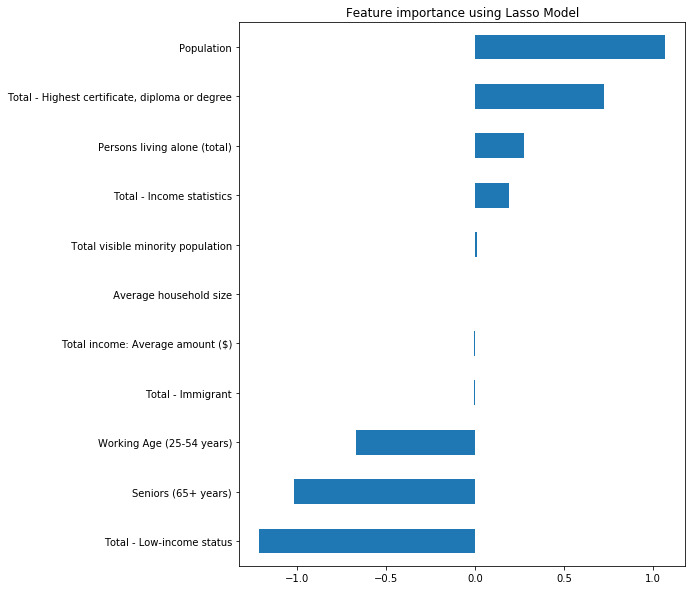

In [13]:
imp_coef = coef.sort_values()

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")